In [2]:
import math
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import cv2, random
from io import BytesIO
from PIL import Image
import requests
import vision_transformer as vits
from itertools import product
import time

In [ ]:
# sinusoidal positional embedding generator
def get_sinusoid_encoding_table(n_position, d_hid):
    # sinusoidal position encoding table  
    def get_angle(pos, i):
        return pos / math.pow(10000, (2 * (i // 2)) / d_hid)
    table = np.array([[get_angle(pos, i) for i in range(d_hid)] for pos in range(n_position)])
    table[:, 0::2] = np.sin(table[:, 0::2])
    table[:, 1::2] = np.cos(table[:, 1::2])
    return torch.FloatTensor(table)

# patch embedding module
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, embed_dim=128):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
    
    def forward(self, x):
        # x (B, C, H, W)
        x = self.proj(x)  
        x = x.flatten(2)   
        x = x.transpose(1, 2)  
        return x

In [3]:
# Scaled Dot-Product Attention and Multi-Head Attention class
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by number of heads"
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = math.sqrt(self.head_dim)
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(dropout)
    
    def forward(self, x, return_attn=False):
        B, N, D = x.shape
        qkv = self.qkv(x)   
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn_scores = (q @ k.transpose(-2, -1)) / self.scale   
        attn = attn_scores.softmax(dim=-1)
        if return_attn:
            self.last_attn = attn.detach()
        attn = self.attn_drop(attn)
        out = attn @ v   
        out = out.transpose(1, 2).reshape(B, N, D)
        out = self.proj(out)
        out = self.proj_drop(out)
        if return_attn:
            return out, attn
        return out

# Transformer Encoder core Block
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, num_heads, dropout=dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        mlp_hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )
    
    def forward(self, x, return_attn=False):
        if return_attn:
            attn_out, attn = self.attn(self.norm1(x), return_attn=True)
            x = x + attn_out
            x = x + self.mlp(self.norm2(x))
            return x, attn
        else:
            x = x + self.attn(self.norm1(x))
            x = x + self.mlp(self.norm2(x))
            return x

# Vision Transformer (ViT) model from the paper with cls token
class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, num_classes=10, embed_dim=128, depth=6, num_heads=4, mlp_ratio=4.0, dropout=0.1, pos_emb_type="1d"):
        super(VisionTransformer, self).__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = self.patch_embed.num_patches
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        if pos_emb_type == "none":
            self.pos_embed = None
        elif pos_emb_type == "1d":
            self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
            nn.init.trunc_normal_(self.pos_embed, std=0.02)
        elif pos_emb_type == "2d":
            grid_size = int(math.sqrt(num_patches))
            self.row_embed = nn.Parameter(torch.zeros(1, grid_size, embed_dim // 2))
            self.col_embed = nn.Parameter(torch.zeros(1, grid_size, embed_dim // 2))
            nn.init.trunc_normal_(self.row_embed, std=0.02)
            nn.init.trunc_normal_(self.col_embed, std=0.02)
        elif pos_emb_type == "sinusoidal":
            pos_embed = get_sinusoid_encoding_table(num_patches + 1, embed_dim).unsqueeze(0)
            self.register_buffer("pos_embed", pos_embed)
        else:
            raise ValueError("Invalid positional embedding type")
        self.pos_emb_type = pos_emb_type

        self.blocks = nn.ModuleList([
            TransformerEncoderLayer(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        self.dropout = nn.Dropout(dropout)
        self._init_weights()
    
    def _init_weights(self):
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.head.weight.data.normal_(mean=0.0, std=0.02)
        if self.head.bias is not None:
            nn.init.zeros_(self.head.bias)
    
    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        if self.pos_emb_type in ["1d", "sinusoidal"]:
            x = x + self.pos_embed
        elif self.pos_emb_type == "2d":
            grid_size = int(math.sqrt(x.shape[1]-1))
            pos_patch = torch.cat((
                self.row_embed.repeat(1, grid_size, 1),
                self.col_embed.repeat(1, grid_size, 1)
            ), dim=-1)
            pos = torch.cat((torch.zeros(1, 1, pos_patch.shape[-1], device=x.device), pos_patch), dim=1)
            x = x + pos

        x = self.dropout(x)
        for block in self.blocks:
            x = block(x)
        x = self.norm(x)
        cls_out = x[:, 0]
        logits = self.head(cls_out)
        return logits

    def get_last_attention_map(self, x):
        device = x.device
        B = x.shape[0]
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        if self.pos_emb_type in ["1d", "sinusoidal"]:
            x = x + self.pos_embed
        elif self.pos_emb_type == "2d":
            grid_size = int(math.sqrt(x.shape[1]-1))
            pos_patch = torch.cat((
                self.row_embed.repeat(1, grid_size, 1),
                self.col_embed.repeat(1, grid_size, 1)
            ), dim=-1)
            pos = torch.cat((torch.zeros(1, 1, pos_patch.shape[-1], device=device), pos_patch), dim=1)
            x = x + pos
        x = self.dropout(x)
        for block in self.blocks[:-1]:
            x = block(x)
        last_block = self.blocks[-1]
        x_norm = last_block.norm1(x)
        out_attn, attn = last_block.attn(x_norm, return_attn=True)
        return attn


In [4]:
# CIFAR-10 data loader with augmentation options
def get_dataloaders(batch_size=256, augment=False, augmentation_type="A"):
    if augment:
        if augmentation_type == "A":   
            transform_train = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
            ])
        elif augmentation_type == "B":  
            transform_train = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                transforms.ToTensor(),
            ])
        elif augmentation_type == "C":   
            transform_train = transforms.Compose([
                transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
                transforms.ToTensor(),
            ])
        else:
            transform_train = transforms.ToTensor()
    else:
        transform_train = transforms.ToTensor()
    transform_test = transforms.ToTensor()
    trainset = torchvision.datasets.CIFAR10(root='./cifar-10-batches-py', train=True,  download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    testset = torchvision.datasets.CIFAR10(root='./cifar-10-batches-py', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    return trainloader, testloader

# training epoch
def train_epoch(model, device, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

# eval on eval set
def evaluate(model, device, dataloader, criterion):
    model.eval()
    correct = 0
    total = 0
    loss_total = 0.0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss_total += criterion(outputs, targets).item()
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += predicted.eq(targets).cpu().sum().item()
    return loss_total / len(dataloader), 100. * correct / total

# training steps
def run_training(config):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Using device:", device)
    train_loader, test_loader = get_dataloaders(batch_size=config.get("batch_size", 256), augment=config.get("augment", False), augmentation_type=config.get("augmentation_type", "A"))
    model = VisionTransformer(
        img_size=32,
        patch_size=config.get("patch_size", 4),
        in_channels=3,
        num_classes=10,
        embed_dim=config.get("embed_dim", 128),
        depth=config.get("depth", 6),
        num_heads=config.get("num_heads", 4),
        mlp_ratio=config.get("mlp_ratio", 4.0),
        dropout=config.get("dropout", 0.1),
        pos_emb_type=config.get("pos_emb_type", "1d"))
    model = model.to(device)
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs")
        model = nn.DataParallel(model)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=config.get("lr", 1e-3), weight_decay=config.get("weight_decay", 5e-2))
    num_epochs = config.get("num_epochs", 50)
    train_losses, test_losses, test_accs = [], [], []
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, device, train_loader, criterion, optimizer)
        test_loss, test_acc = evaluate(model, device, test_loader, criterion)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        print(f"Epoch {epoch+1}/{num_epochs}: Train loss = {train_loss:.4f}, Test loss = {test_loss:.4f}, Test acc = {test_acc:.2f}%")
    return train_losses, test_losses, test_accs, model

In [6]:
# loss and accuracy plotting
def plot_loss_curves(train_losses, test_losses, title="Loss Curves"):
    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

def plot_accuracy(test_accs, title="Test Accuracy"):
    plt.figure()
    plt.plot(test_accs, label="Test Accuracy")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.show()

# Patch Size


--- Training with patch size 2 ---
Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Using 4 GPUs
Epoch 1/50: Train loss = 2.2338, Test loss = 2.0923, Test acc = 21.37%
Epoch 2/50: Train loss = 2.0591, Test loss = 2.0063, Test acc = 24.54%
Epoch 3/50: Train loss = 1.9591, Test loss = 1.8881, Test acc = 28.19%
Epoch 4/50: Train loss = 1.8787, Test loss = 1.8049, Test acc = 32.41%
Epoch 5/50: Train loss = 1.8028, Test loss = 1.7626, Test acc = 33.49%
Epoch 6/50: Train loss = 1.7251, Test loss = 1.6611, Test acc = 38.02%
Epoch 7/50: Train loss = 1.6601, Test loss = 1.5974, Test acc = 40.55%
Epoch 8/50: Train loss = 1.6014, Test loss = 1.5809, Test acc = 41.73%
Epoch 9/50: Train loss = 1.5502, Test loss = 1.4859, Test acc = 44.95%
Epoch 10/50: Train loss = 1.4963, Test loss = 1.4805, Test acc = 45.67%
Epoch 11/50: Train loss = 1.4758, Test loss = 1.4194, Test acc = 48.34%
Epoch 12/50: Train loss = 1.4163, Test loss = 1.3625, Test acc = 50.32%
E

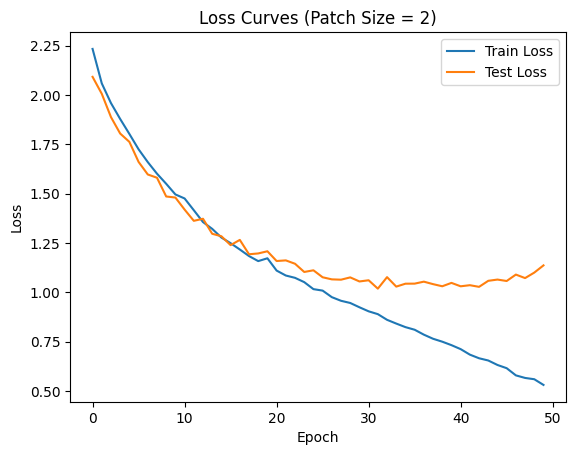

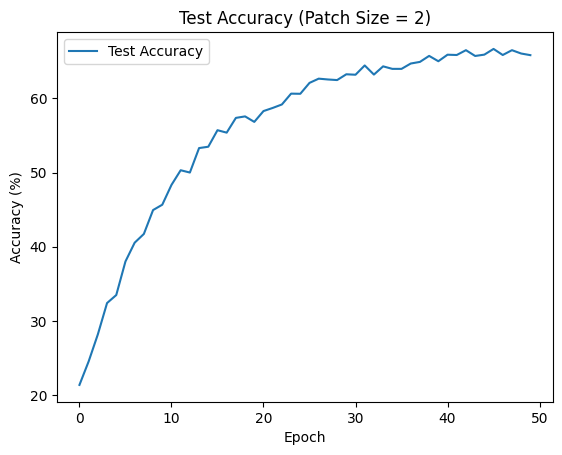


--- Training with patch size 4 ---
Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Using 4 GPUs
Epoch 1/50: Train loss = 2.3160, Test loss = 2.1663, Test acc = 19.25%
Epoch 2/50: Train loss = 2.1039, Test loss = 2.0313, Test acc = 22.38%
Epoch 3/50: Train loss = 1.9942, Test loss = 1.9292, Test acc = 27.40%
Epoch 4/50: Train loss = 1.8896, Test loss = 1.8213, Test acc = 30.88%
Epoch 5/50: Train loss = 1.7943, Test loss = 1.8120, Test acc = 32.24%
Epoch 6/50: Train loss = 1.7604, Test loss = 1.6858, Test acc = 36.54%
Epoch 7/50: Train loss = 1.6744, Test loss = 1.6181, Test acc = 39.25%
Epoch 8/50: Train loss = 1.6093, Test loss = 1.5513, Test acc = 42.35%
Epoch 9/50: Train loss = 1.5752, Test loss = 1.5465, Test acc = 42.25%
Epoch 10/50: Train loss = 1.5114, Test loss = 1.4664, Test acc = 45.67%
Epoch 11/50: Train loss = 1.4637, Test loss = 1.4277, Test acc = 47.31%
Epoch 12/50: Train loss = 1.4086, Test loss = 1.3861, Test acc = 49.82%
E

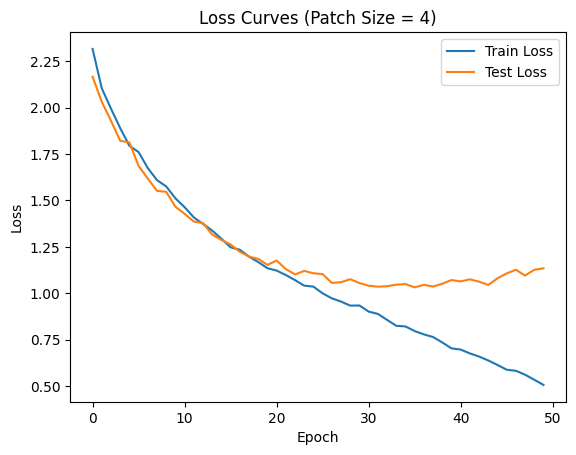

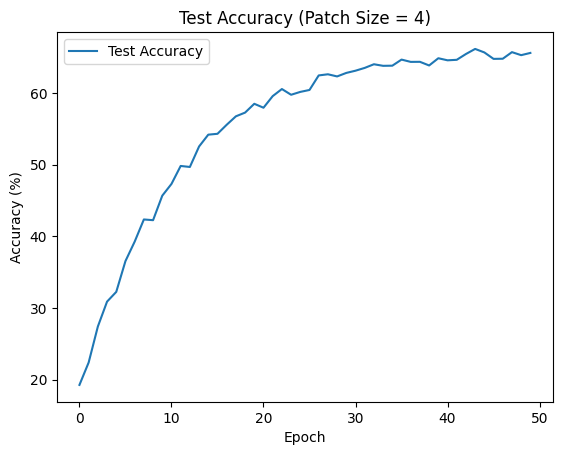


--- Training with patch size 8 ---
Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Using 4 GPUs
Epoch 1/50: Train loss = 2.2605, Test loss = 2.1227, Test acc = 20.70%
Epoch 2/50: Train loss = 2.0522, Test loss = 1.9551, Test acc = 26.13%
Epoch 3/50: Train loss = 1.9362, Test loss = 1.8705, Test acc = 29.31%
Epoch 4/50: Train loss = 1.8590, Test loss = 1.7984, Test acc = 33.30%
Epoch 5/50: Train loss = 1.7722, Test loss = 1.6958, Test acc = 36.90%
Epoch 6/50: Train loss = 1.7010, Test loss = 1.6398, Test acc = 37.78%
Epoch 7/50: Train loss = 1.6380, Test loss = 1.5840, Test acc = 41.45%
Epoch 8/50: Train loss = 1.5702, Test loss = 1.5420, Test acc = 43.13%
Epoch 9/50: Train loss = 1.5212, Test loss = 1.4686, Test acc = 45.91%
Epoch 10/50: Train loss = 1.4870, Test loss = 1.4401, Test acc = 46.84%
Epoch 11/50: Train loss = 1.4277, Test loss = 1.4184, Test acc = 47.37%
Epoch 12/50: Train loss = 1.3814, Test loss = 1.3716, Test acc = 50.31%
E

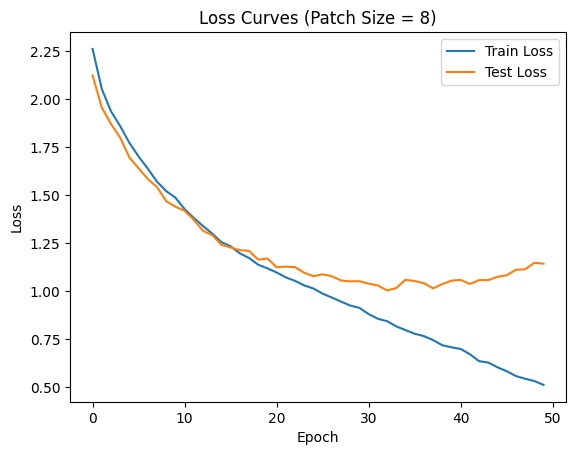

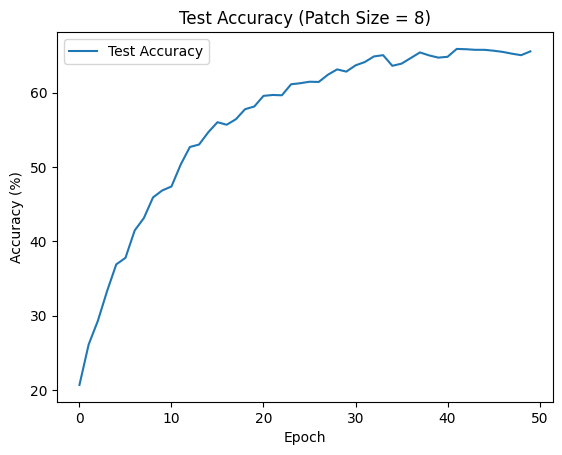

In [6]:
# Patch Size Variation, 2 4 8 path size
patch_sizes = [2, 4, 8]
results_patch = {}
for ps in patch_sizes:
    print(f"\n--- Training with patch size {ps} ---")
    config = {
        "patch_size": 4,
        "embed_dim": 256,          
        "depth": 8,                
        "num_heads": 8,
        "mlp_ratio": 4.0,
        "dropout": 0.1,
        "lr": 3e-4,                
        "weight_decay": 0.1,
        "num_epochs": 50,         
        "augment": True,
        "augmentation_type": "D",  
        "pos_emb_type": "1d",
        "batch_size": 1000        
    }
    train_losses, test_losses, test_accs, model = run_training(config)
    results_patch[ps] = {"train": train_losses, "test": test_losses, "acc": test_accs}
    plot_loss_curves(train_losses, test_losses, title=f"Loss Curves (Patch Size = {ps})")
    plot_accuracy(test_accs, title=f"Test Accuracy (Patch Size = {ps})")

## Training Summary: Patch Size Comparison (ViT)

---

### Patch Size = 2
- **Initial Test Accuracy:** 21.37%
- **Final Test Accuracy:** 65.84%
- **Best Accuracy:** **66.68%** (Epoch 46)
- **Final Train Loss:** 0.5307
- **Final Test Loss:** 1.1366

---

### Patch Size = 4
- **Initial Test Accuracy:** 19.25%
- **Final Test Accuracy:** 65.60%
- **Best Accuracy:** **66.16%** (Epoch 44)
- **Final Train Loss:** 0.5062
- **Final Test Loss:** 1.1341

---

### Patch Size = 8
- **Initial Test Accuracy:** 20.70%
- **Final Test Accuracy:** 65.53%
- **Best Accuracy:** **65.86%** (Epoch 42)
- **Final Train Loss:** 0.5131
- **Final Test Loss:** 1.1436

---

### Summary Insights
- All patch sizes converge to ~65-66% test accuracy.
- Patch size 2 achieved slightly **earlier** improvements but didn't outperform the others significantly.
- Patch size 4 and 8 offer comparable accuracy while reducing computation (larger patch = fewer tokens).
- No clear winner in accuracy, but **patch size 8** may offer best efficiency-performance trade-off.

# Hyper Param


[01/3] depth=12, bs=256, lr=5.00e-04
Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Using 4 GPUs
Epoch 1/50: Train loss = 2.0467, Test loss = 1.8009, Test acc = 31.96%
Epoch 2/50: Train loss = 1.7691, Test loss = 1.6167, Test acc = 38.83%
Epoch 3/50: Train loss = 1.6493, Test loss = 1.5052, Test acc = 44.46%
Epoch 4/50: Train loss = 1.5517, Test loss = 1.4026, Test acc = 48.95%
Epoch 5/50: Train loss = 1.4837, Test loss = 1.3661, Test acc = 49.45%
Epoch 6/50: Train loss = 1.4410, Test loss = 1.3473, Test acc = 51.24%
Epoch 7/50: Train loss = 1.4036, Test loss = 1.3124, Test acc = 51.84%
Epoch 8/50: Train loss = 1.3677, Test loss = 1.3096, Test acc = 52.42%
Epoch 9/50: Train loss = 1.3397, Test loss = 1.2921, Test acc = 53.41%
Epoch 10/50: Train loss = 1.3096, Test loss = 1.2088, Test acc = 56.49%
Epoch 11/50: Train loss = 1.2810, Test loss = 1.1885, Test acc = 57.57%
Epoch 12/50: Train loss = 1.2585, Test loss = 1.2017, Test acc = 56.49%

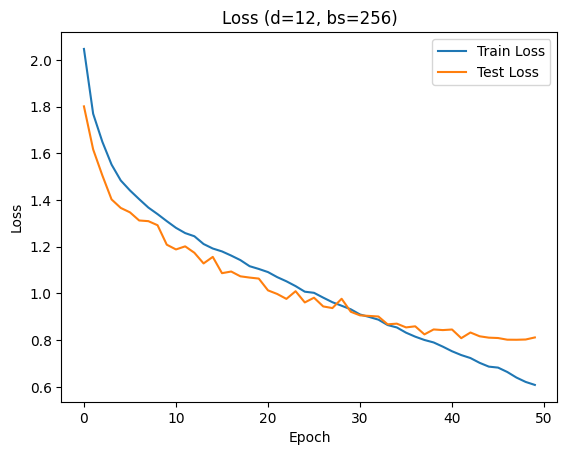

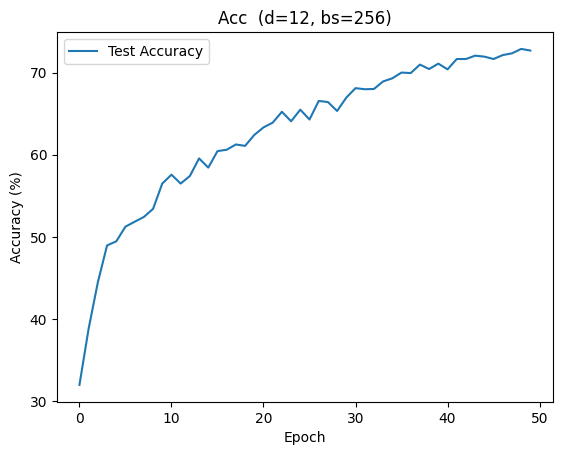


[02/3] depth=15, bs=256, lr=5.00e-04
Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Using 4 GPUs
Epoch 1/50: Train loss = 2.0103, Test loss = 1.7947, Test acc = 31.34%
Epoch 2/50: Train loss = 1.7748, Test loss = 1.6339, Test acc = 38.04%
Epoch 3/50: Train loss = 1.6549, Test loss = 1.5103, Test acc = 44.26%
Epoch 4/50: Train loss = 1.5612, Test loss = 1.4414, Test acc = 46.63%
Epoch 5/50: Train loss = 1.4843, Test loss = 1.3668, Test acc = 50.16%
Epoch 6/50: Train loss = 1.4331, Test loss = 1.3076, Test acc = 51.74%
Epoch 7/50: Train loss = 1.4015, Test loss = 1.2767, Test acc = 53.08%
Epoch 8/50: Train loss = 1.3709, Test loss = 1.2998, Test acc = 53.10%
Epoch 9/50: Train loss = 1.3352, Test loss = 1.2494, Test acc = 54.77%
Epoch 10/50: Train loss = 1.3134, Test loss = 1.2337, Test acc = 55.41%
Epoch 11/50: Train loss = 1.2920, Test loss = 1.1800, Test acc = 57.03%
Epoch 12/50: Train loss = 1.2783, Test loss = 1.2031, Test acc = 56.46%

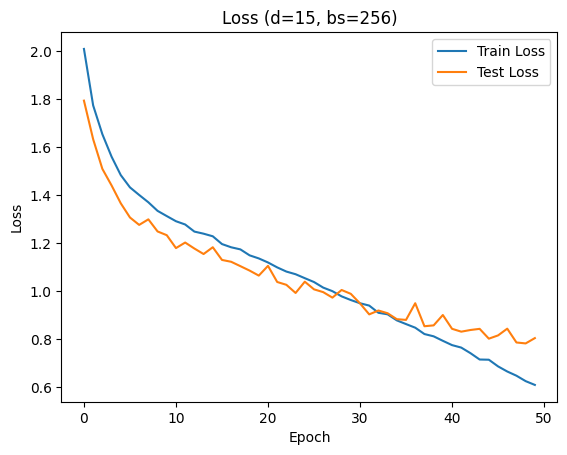

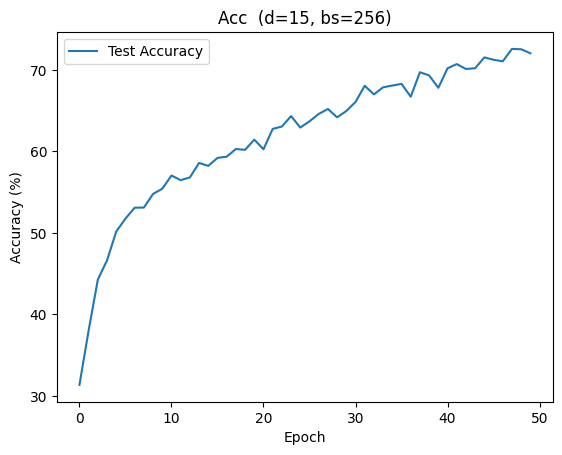


[03/3] depth=18, bs=256, lr=5.00e-04
Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Using 4 GPUs
Epoch 1/50: Train loss = 2.0369, Test loss = 1.8832, Test acc = 29.61%
Epoch 2/50: Train loss = 1.7747, Test loss = 1.6455, Test acc = 38.44%
Epoch 3/50: Train loss = 1.6493, Test loss = 1.5485, Test acc = 43.07%
Epoch 4/50: Train loss = 1.5600, Test loss = 1.5549, Test acc = 44.41%
Epoch 5/50: Train loss = 1.5012, Test loss = 1.3834, Test acc = 49.34%
Epoch 6/50: Train loss = 1.4334, Test loss = 1.3378, Test acc = 51.97%
Epoch 7/50: Train loss = 1.4049, Test loss = 1.3479, Test acc = 51.97%
Epoch 8/50: Train loss = 1.3843, Test loss = 1.2645, Test acc = 54.24%
Epoch 9/50: Train loss = 1.3488, Test loss = 1.2559, Test acc = 54.10%
Epoch 10/50: Train loss = 1.3248, Test loss = 1.2256, Test acc = 55.74%
Epoch 11/50: Train loss = 1.3072, Test loss = 1.2289, Test acc = 54.64%
Epoch 12/50: Train loss = 1.2923, Test loss = 1.2113, Test acc = 56.02%

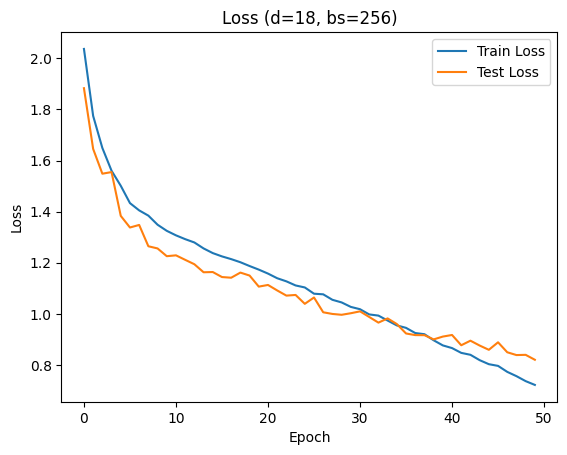

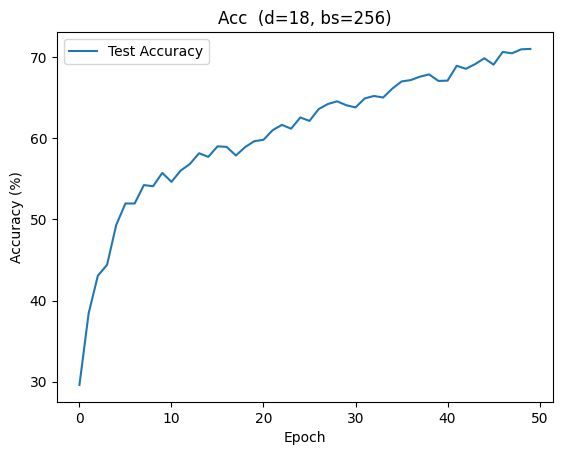


============= BEST (≤50 epochs) =============
accuracy: 72.69%
{'patch_size': 4, 'embed_dim': 192, 'depth': 12, 'num_heads': 4, 'mlp_ratio': 4.0, 'dropout': 0.0, 'lr': 0.0005, 'weight_decay': 0.02, 'num_epochs': 50, 'augment': True, 'augmentation_type': 'B', 'pos_emb_type': '1d', 'batch_size': 256}


In [6]:
depths       = [12, 15, 18]
base_lrs     = [1e-3]
batch_sizes  = [256]                  
search_space = list(product(depths, base_lrs, batch_sizes))
best_cfg, best_acc = None, 0.0
results_hp = {}
for ix, (depth, base_lr, bs) in enumerate(search_space, 1):
    lr = base_lr * bs / 512                 
    heads = max(4, 192 // 64)               
    heads = 4
    cfg = dict(
        patch_size   = 4,
        embed_dim    = 192,
        depth        = depth,
        num_heads    = heads,
        mlp_ratio    = 4.0,
        dropout      = 0.0,                  
        lr           = lr,
        weight_decay = 0.02,                 
        num_epochs   = 50,
        augment      = True,
        augmentation_type = "D",             
        pos_emb_type = "1d",
        batch_size   = bs
    )
    print(f"\n[{ix:02}/{len(search_space)}] depth={depth}, bs={bs}, lr={lr:.2e}")
    t0 = time.time()
    tr_l, te_l, te_a, model = run_training(cfg)
    dt = time.time() - t0
    acc = te_a[-1]
    results_hp[f"d{depth}_bs{bs}_lr{base_lr}"] = {"train": tr_l, "test": te_l, "acc": te_a, "config": cfg, "time_min": dt/60}
    print(f"→ acc: {acc:5.2f}% | run time: {dt/60:4.1f} min")
    plot_loss_curves(tr_l, te_l, title=f"Loss (d={depth}, bs={bs})")
    plot_accuracy(te_a, title=f"Acc  (d={depth}, bs={bs})")
    if acc > best_acc:
        best_acc, best_cfg, best_model = acc, cfg, model

print("\n============= BEST (≤50 epochs) =============")
print(f"accuracy: {best_acc:.2f}%")
print(best_cfg)


[01/1] depth=18, bs=2200, lr=1.00e-03
Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Using 4 GPUs
Epoch 1/50: Train loss = 2.2861, Test loss = 2.1436, Test acc = 19.82%
Epoch 2/50: Train loss = 2.1062, Test loss = 2.0290, Test acc = 22.44%
Epoch 3/50: Train loss = 2.0249, Test loss = 1.9559, Test acc = 24.73%
Epoch 4/50: Train loss = 1.9816, Test loss = 1.9395, Test acc = 24.57%
Epoch 5/50: Train loss = 1.9326, Test loss = 1.8467, Test acc = 31.16%
Epoch 6/50: Train loss = 1.8434, Test loss = 1.7627, Test acc = 35.18%
Epoch 7/50: Train loss = 1.7868, Test loss = 1.7277, Test acc = 37.29%
Epoch 8/50: Train loss = 1.7488, Test loss = 1.6720, Test acc = 39.89%
Epoch 9/50: Train loss = 1.6900, Test loss = 1.6013, Test acc = 42.95%
Epoch 10/50: Train loss = 1.6546, Test loss = 1.5770, Test acc = 44.18%
Epoch 11/50: Train loss = 1.6438, Test loss = 1.5381, Test acc = 46.16%
Epoch 12/50: Train loss = 1.5953, Test loss = 1.5075, Test acc = 47.84

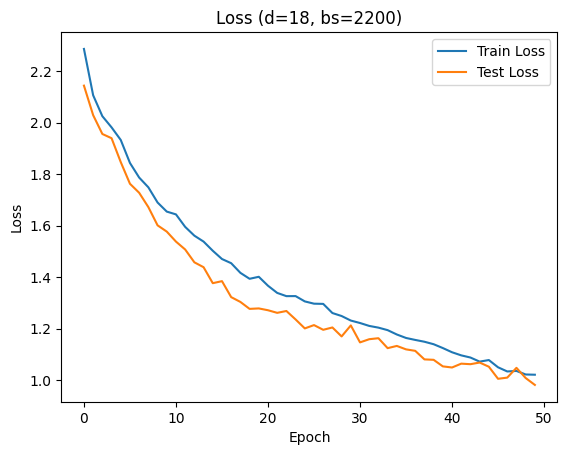

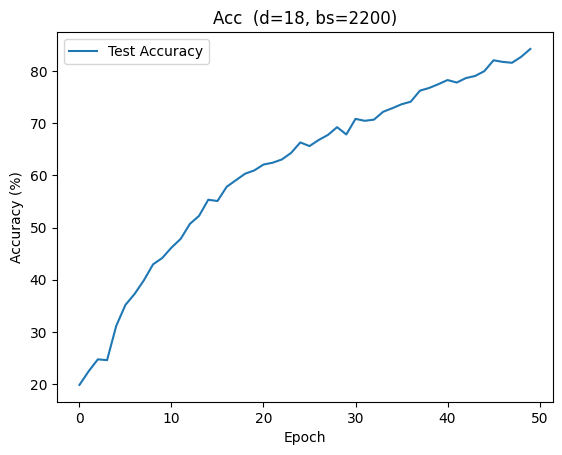


============= BEST (≤50 epochs) =============
accuracy: 84.28%
{'patch_size': 4, 'embed_dim': 192, 'depth': 18, 'num_heads': 4, 'mlp_ratio': 4.0, 'dropout': 0.0, 'lr': 0.001, 'weight_decay': 0.02, 'num_epochs': 50, 'augment': True, 'augmentation_type': 'B', 'pos_emb_type': '1d', 'batch_size': 2200}


In [ ]:
depths       = [18]
base_lrs     = [1e-3]
batch_sizes  = [2200]                  
search_space = list(product(depths, base_lrs, batch_sizes))
best_cfg, best_acc = None, 0.0
results_hp = {}
for ix, (depth, base_lr, bs) in enumerate(search_space, 1):
    lr = base_lr      
    heads = max(4, 192 // 64)              
    heads = 4
    cfg = dict(
        patch_size   = 4,
        embed_dim    = 192,
        depth        = depth,
        num_heads    = heads,
        mlp_ratio    = 4.0,
        dropout      = 0.0,                  
        lr           = lr,
        weight_decay = 0.02,                 
        num_epochs   = 50,
        augment      = True,
        augmentation_type = "D",             
        pos_emb_type = "1d",
        batch_size   = bs
    )
    print(f"\n[{ix:02}/{len(search_space)}] depth={depth}, bs={bs}, lr={lr:.2e}")
    t0 = time.time()
    tr_l, te_l, te_a, model = run_training(cfg)
    dt = time.time() - t0
    acc = te_a[-1]
    results_hp[f"d{depth}_bs{bs}_lr{base_lr}"] = {
        "train": tr_l, "test": te_l, "acc": te_a, "config": cfg,
    }
    print(f"→ acc: {acc:5.2f}% | run time: {dt/60:4.1f} min")
    plot_loss_curves(tr_l, te_l, title=f"Loss (d={depth}, bs={bs})")
    plot_accuracy(te_a, title=f"Acc  (d={depth}, bs={bs})")
    if acc > best_acc:
        best_acc, best_cfg, best_model = acc, cfg, model
print("\n============= BEST (≤50 epochs) =============")
print(f"accuracy: {best_acc:.2f}%")
print(best_cfg)

In [9]:
best_cfg = {'patch_size': 4, 'embed_dim': 192, 'depth': 12, 'num_heads': 4, 'mlp_ratio': 4.0, 'dropout': 0.0, 'lr': 0.001, 'weight_decay': 0.02, 'num_epochs': 50, 'augment': True, 'augmentation_type': 'D', 'pos_emb_type': '1d', 'batch_size': 3000}

### ViT Training Summary 

### Final Metrics
- **Final Test Accuracy:** **84.28%**
- **Best Epoch:** 50
- **Final Test Loss:** 0.9818
- **Total Runtime:** 19.8 minutes

---

### Previous Best Configuration (≤50 Epochs)

| Metric         | Value       |
|----------------|-------------|
| **Accuracy**   | **72.69%**  |
| Patch Size     | 4           |
| Embed Dim      | 192         |
| Depth          | 12          |
| Heads          | 4           |
| MLP Ratio      | 4.0         |
| Dropout        | 0.0         |
| LR             | 5e-4        |
| Weight Decay   | 0.02        |
| Epochs         | 50          |
| Augmentation   | (Type D) |
| Pos Embedding  | 1D          |
| Batch Size     | 256         |

---

### Improvement
- **+11.59% Accuracy Boost** (from 72.69% → 84.28%)
- **Lower test loss** and better generalization
- Optimal results achieved with **deeper network** (depth=18) and **larger batch size (2200)**


---

# Positional Embeddings


--- Training with positional embedding: none ---
Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Using 4 GPUs
Epoch 1/50: Train loss = 2.3222, Test loss = 2.2195, Test acc = 16.40%
Epoch 2/50: Train loss = 2.1476, Test loss = 2.0672, Test acc = 20.70%
Epoch 3/50: Train loss = 2.0589, Test loss = 2.0242, Test acc = 23.43%
Epoch 4/50: Train loss = 2.0059, Test loss = 1.9583, Test acc = 25.28%
Epoch 5/50: Train loss = 1.9794, Test loss = 1.9140, Test acc = 27.77%
Epoch 6/50: Train loss = 1.9251, Test loss = 1.9183, Test acc = 28.26%
Epoch 7/50: Train loss = 1.8716, Test loss = 1.8119, Test acc = 33.41%
Epoch 8/50: Train loss = 1.8233, Test loss = 1.8173, Test acc = 33.25%
Epoch 9/50: Train loss = 1.7987, Test loss = 1.7172, Test acc = 36.51%
Epoch 10/50: Train loss = 1.7682, Test loss = 1.7163, Test acc = 36.76%
Epoch 11/50: Train loss = 1.7411, Test loss = 1.6933, Test acc = 38.73%
Epoch 12/50: Train loss = 1.7079, Test loss = 1.6825, Test 

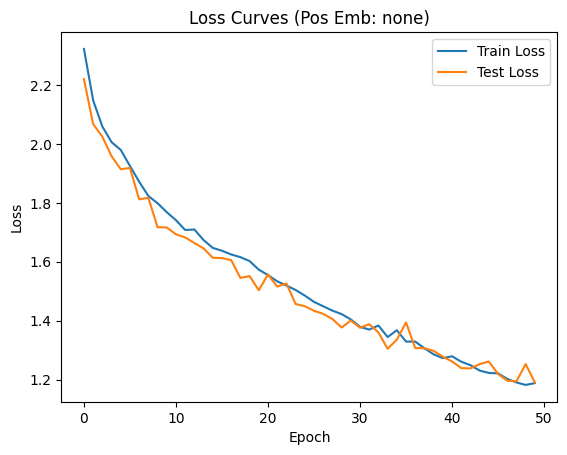

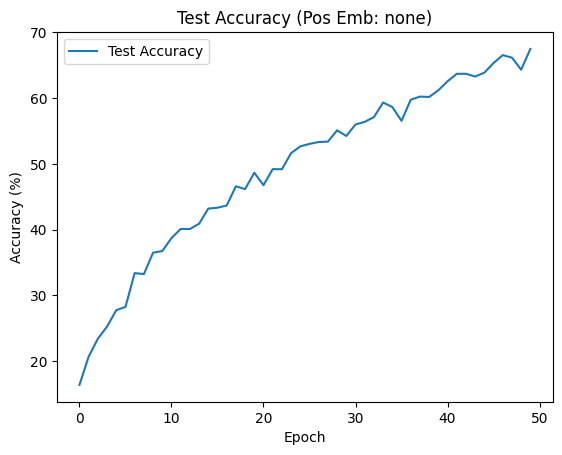


--- Training with positional embedding: 1d ---
Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Using 4 GPUs
Epoch 1/50: Train loss = 2.3279, Test loss = 2.2915, Test acc = 14.08%
Epoch 2/50: Train loss = 2.2106, Test loss = 2.0780, Test acc = 21.22%
Epoch 3/50: Train loss = 2.0684, Test loss = 2.0010, Test acc = 22.67%
Epoch 4/50: Train loss = 2.0187, Test loss = 1.9740, Test acc = 24.44%
Epoch 5/50: Train loss = 1.9668, Test loss = 1.9018, Test acc = 26.65%
Epoch 6/50: Train loss = 1.9235, Test loss = 1.8539, Test acc = 30.49%
Epoch 7/50: Train loss = 1.8503, Test loss = 1.8061, Test acc = 33.28%
Epoch 8/50: Train loss = 1.8056, Test loss = 1.7121, Test acc = 36.99%
Epoch 9/50: Train loss = 1.7643, Test loss = 1.6801, Test acc = 38.70%
Epoch 10/50: Train loss = 1.7156, Test loss = 1.6449, Test acc = 40.66%
Epoch 11/50: Train loss = 1.6869, Test loss = 1.6479, Test acc = 41.30%
Epoch 12/50: Train loss = 1.6679, Test loss = 1.5894, Test ac

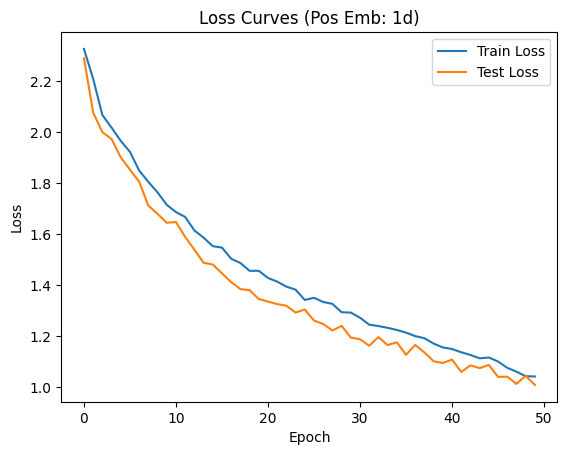

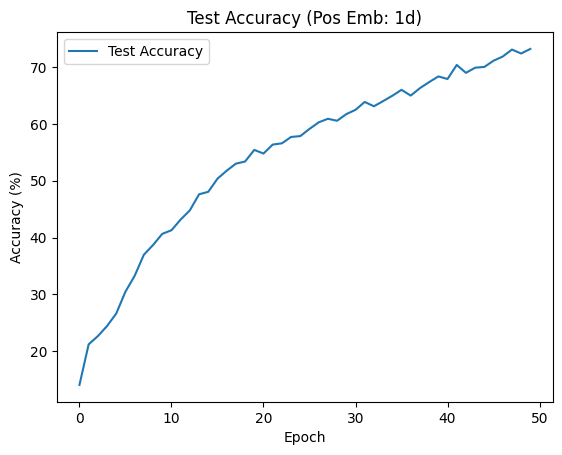


--- Training with positional embedding: 2d ---
Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Using 4 GPUs
Epoch 1/50: Train loss = 2.3279, Test loss = 2.2308, Test acc = 14.66%
Epoch 2/50: Train loss = 2.1812, Test loss = 2.1120, Test acc = 18.18%
Epoch 3/50: Train loss = 2.0927, Test loss = 2.0373, Test acc = 21.61%
Epoch 4/50: Train loss = 2.0414, Test loss = 1.9936, Test acc = 25.61%
Epoch 5/50: Train loss = 1.9928, Test loss = 1.9372, Test acc = 27.95%
Epoch 6/50: Train loss = 1.9542, Test loss = 1.8653, Test acc = 30.08%
Epoch 7/50: Train loss = 1.8853, Test loss = 1.8167, Test acc = 32.61%
Epoch 8/50: Train loss = 1.8346, Test loss = 1.7624, Test acc = 35.01%
Epoch 9/50: Train loss = 1.8028, Test loss = 1.7569, Test acc = 35.56%
Epoch 10/50: Train loss = 1.7704, Test loss = 1.7170, Test acc = 36.76%
Epoch 11/50: Train loss = 1.7444, Test loss = 1.7399, Test acc = 37.34%
Epoch 12/50: Train loss = 1.7305, Test loss = 1.6603, Test ac

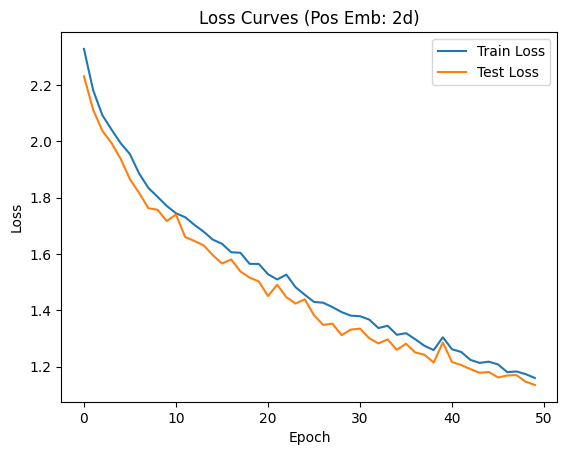

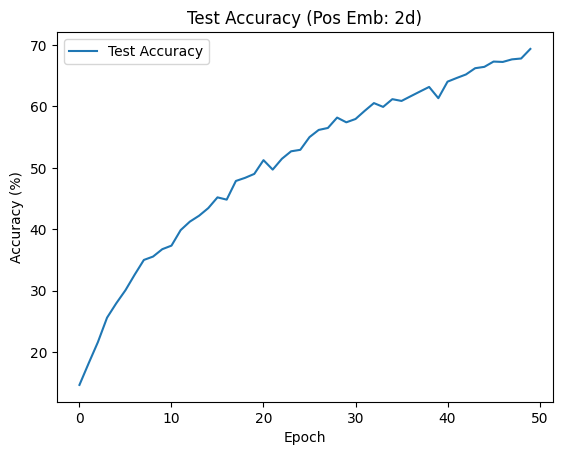


--- Training with positional embedding: sinusoidal ---
Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Using 4 GPUs
Epoch 1/50: Train loss = 2.3522, Test loss = 2.3043, Test acc = 11.64%
Epoch 2/50: Train loss = 2.3010, Test loss = 2.2955, Test acc = 11.03%
Epoch 3/50: Train loss = 2.2629, Test loss = 2.1822, Test acc = 16.10%
Epoch 4/50: Train loss = 2.1409, Test loss = 2.0333, Test acc = 22.67%
Epoch 5/50: Train loss = 2.0485, Test loss = 1.9779, Test acc = 25.19%
Epoch 6/50: Train loss = 2.0015, Test loss = 1.9525, Test acc = 29.02%
Epoch 7/50: Train loss = 1.9624, Test loss = 1.9229, Test acc = 30.24%
Epoch 8/50: Train loss = 1.9152, Test loss = 1.8225, Test acc = 35.02%
Epoch 9/50: Train loss = 1.8521, Test loss = 1.7950, Test acc = 36.99%
Epoch 10/50: Train loss = 1.8106, Test loss = 1.6958, Test acc = 41.31%
Epoch 11/50: Train loss = 1.7528, Test loss = 1.6358, Test acc = 42.89%
Epoch 12/50: Train loss = 1.7143, Test loss = 1.5941,

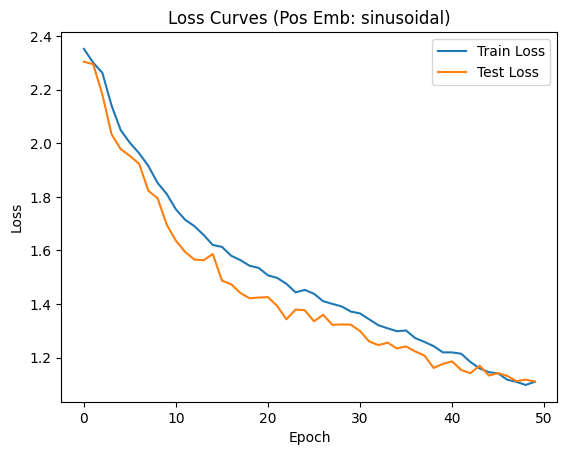

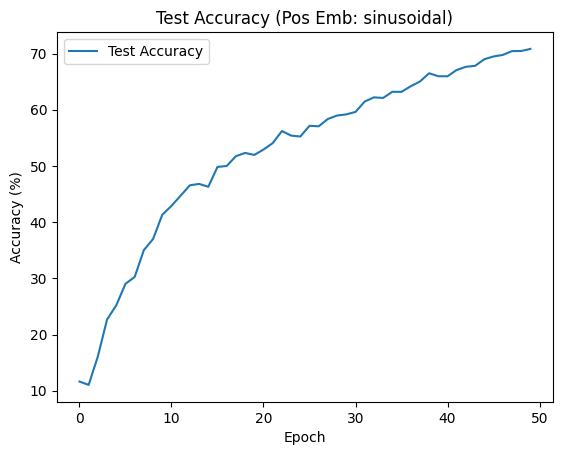

In [9]:
# Positional Embedding Variants 
pos_emb_variants = ["none", "1d", "2d", "sinusoidal"]
results_pos = {}
base_config = best_cfg.copy()  
model = VisionTransformer(
        img_size=32,
        patch_size=4,
        in_channels=3,
        num_classes=10,
        embed_dim=192,
        depth=12,
        num_heads=4,
        mlp_ratio=4.0,
        dropout=0.0,
        pos_emb_type="1d"
    )
for pe in pos_emb_variants:
    print(f"\n--- Training with positional embedding: {pe} ---")
    config_pos = base_config.copy()
    config_pos["pos_emb_type"] = pe
    train_losses_pe, test_losses_pe, test_accs_pe, model = run_training(config_pos)
    results_pos[pe] = {"train": train_losses_pe, "test": test_losses_pe, "acc": test_accs_pe}
    plot_loss_curves(train_losses_pe, test_losses_pe, title=f"Loss Curves (Pos Emb: {pe})")
    plot_accuracy(test_accs_pe, title=f"Test Accuracy (Pos Emb: {pe})")

## Positional Embedding Evaluation Report (ViT)

All experiments use:
- Patch size: 4
- Embed dim: 192
- Depth: 12
- Heads: 4
- MLP ratio: 4.0
- Batch size: 256
- Epochs: 50
- Dataset: CIFAR-10

---

### Final Test Accuracy

| Positional Embedding | Final Test Accuracy |
|----------------------|---------------------|
| None                 | **67.50%**          |
| 1D Learnable         | **73.20%**          |
| 2D Learnable         | **69.37%**          |
| Sinusoidal           | **70.82%**          |

---

### Loss Curve Comparison

| Positional Embedding | Final Train Loss | Final Test Loss |
|----------------------|------------------|-----------------|
| None                 | 1.1884           | 1.1904          |
| 1D Learnable         | 1.0413           | 1.0082          |
| 2D Learnable         | 1.1597           | 1.1351          |
| Sinusoidal           | 1.1095           | 1.1107          |

---

### Key Observations

- **1D Learnable Positional Embedding** achieves **highest test accuracy (73.20%)** and **lowest test loss**, indicating superior performance and generalization.
- **2D Learnable** and **Sinusoidal** embeddings perform **better than no positional encoding**, but fall slightly behind 1D.
- **No positional embedding** consistently underperforms in both accuracy and convergence, confirming the **importance of spatial information**.

---

### Accuracy Trend Summary (Top 3)

| Epoch | 1D Accuracy | Sinusoidal Accuracy | 2D Accuracy |
|-------|-------------|---------------------|-------------|
| 25    | 57.86%      | 55.23%              | 52.94%      |
| 40    | 68.36%      | 65.96%              | 61.35%      |
| 50    | 73.20%      | 70.82%              | 69.37%      |

---

### Conclusion

Positional embeddings significantly impact performance in ViTs.  
**1D learnable embeddings** are most effective on this setup, while **sinusoidal embeddings** offer a strong lightweight alternative.

---

# Data Augmentation


--- Training with Data Augmentation Variant A ---
Using device: cuda


Files already downloaded and verified
Files already downloaded and verified
Using 4 GPUs
Epoch 1/50: Train loss = 2.2923, Test loss = 2.1608, Test acc = 18.65%
Epoch 2/50: Train loss = 2.1323, Test loss = 2.0826, Test acc = 19.92%
Epoch 3/50: Train loss = 2.0587, Test loss = 1.9970, Test acc = 22.51%
Epoch 4/50: Train loss = 1.9986, Test loss = 1.9693, Test acc = 24.34%
Epoch 5/50: Train loss = 1.9625, Test loss = 1.8984, Test acc = 27.32%
Epoch 6/50: Train loss = 1.8949, Test loss = 1.8390, Test acc = 32.06%
Epoch 7/50: Train loss = 1.8313, Test loss = 1.7400, Test acc = 35.24%
Epoch 8/50: Train loss = 1.7755, Test loss = 1.6976, Test acc = 36.68%
Epoch 9/50: Train loss = 1.7147, Test loss = 1.8764, Test acc = 32.55%
Epoch 10/50: Train loss = 1.7725, Test loss = 1.6303, Test acc = 41.34%
Epoch 11/50: Train loss = 1.6642, Test loss = 1.5495, Test acc = 43.67%
Epoch 12/50: Train loss = 1.6170, Test loss = 1.5066, Test acc = 45.47%
Epoch 13/50: Train loss = 1.5892, Test loss = 1.4922, Te

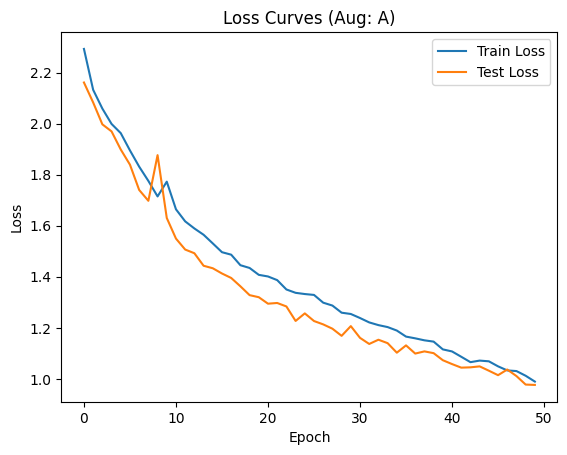

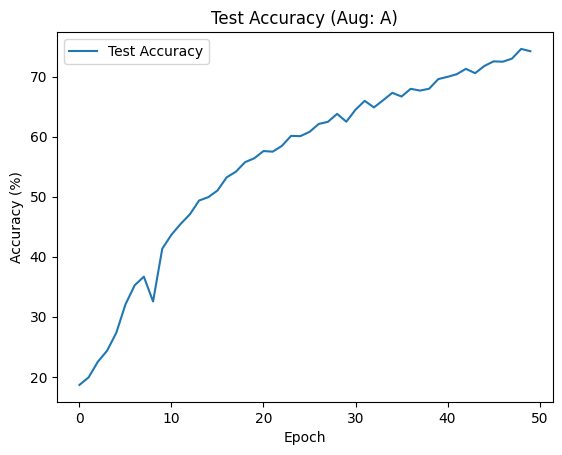

Final Test Accuracy for Augmentation A: 74.23%

--- Training with Data Augmentation Variant B ---
Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Using 4 GPUs
Epoch 1/50: Train loss = 2.3321, Test loss = 2.2970, Test acc = 10.60%
Epoch 2/50: Train loss = 2.2564, Test loss = 2.1807, Test acc = 17.40%
Epoch 3/50: Train loss = 2.1266, Test loss = 2.0839, Test acc = 18.76%
Epoch 4/50: Train loss = 2.0596, Test loss = 1.9962, Test acc = 22.67%
Epoch 5/50: Train loss = 2.0017, Test loss = 1.9535, Test acc = 25.15%
Epoch 6/50: Train loss = 1.9669, Test loss = 1.9117, Test acc = 26.79%
Epoch 7/50: Train loss = 1.8955, Test loss = 1.8106, Test acc = 30.43%
Epoch 8/50: Train loss = 1.8310, Test loss = 1.7490, Test acc = 34.27%
Epoch 9/50: Train loss = 1.7825, Test loss = 1.7120, Test acc = 36.51%
Epoch 10/50: Train loss = 1.7423, Test loss = 1.6697, Test acc = 37.99%
Epoch 11/50: Train loss = 1.7003, Test loss = 1.6018, Test acc = 42.20%
Epoch 12/50

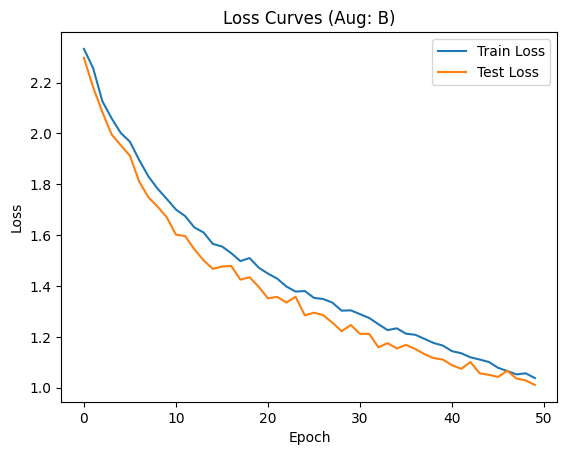

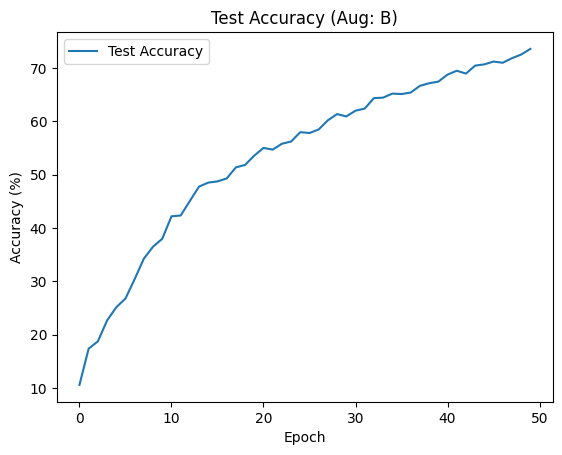

Final Test Accuracy for Augmentation B: 73.57%

--- Training with Data Augmentation Variant C ---
Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Using 4 GPUs
Epoch 1/50: Train loss = 2.2736, Test loss = 2.1452, Test acc = 18.64%
Epoch 2/50: Train loss = 2.1090, Test loss = 2.0297, Test acc = 21.76%
Epoch 3/50: Train loss = 2.0123, Test loss = 1.9375, Test acc = 27.42%
Epoch 4/50: Train loss = 1.9803, Test loss = 1.8843, Test acc = 27.63%
Epoch 5/50: Train loss = 1.8853, Test loss = 1.8044, Test acc = 30.63%
Epoch 6/50: Train loss = 1.8142, Test loss = 1.7365, Test acc = 35.26%
Epoch 7/50: Train loss = 1.7981, Test loss = 1.7419, Test acc = 35.51%
Epoch 8/50: Train loss = 1.7452, Test loss = 1.6453, Test acc = 39.87%
Epoch 9/50: Train loss = 1.7060, Test loss = 1.6130, Test acc = 41.91%
Epoch 10/50: Train loss = 1.6934, Test loss = 1.6344, Test acc = 40.63%
Epoch 11/50: Train loss = 1.6694, Test loss = 1.5795, Test acc = 43.07%
Epoch 12/50

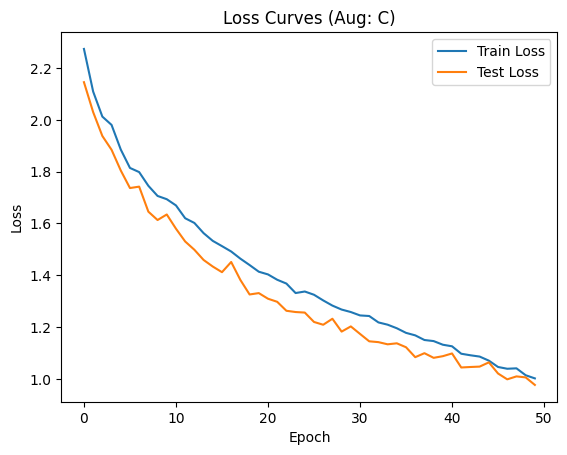

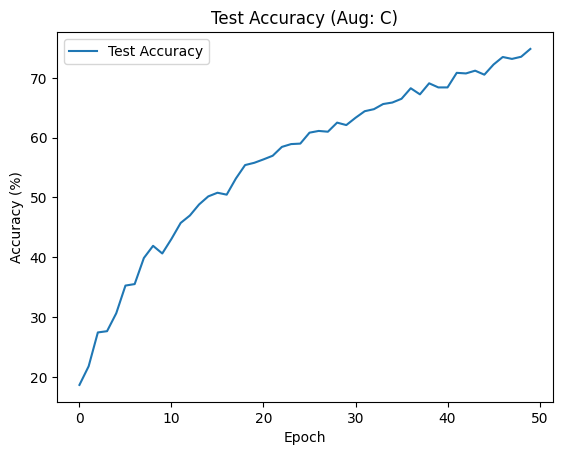

Final Test Accuracy for Augmentation C: 74.85%

--- Training with Data Augmentation Variant D ---
Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Using 4 GPUs
Epoch 1/50: Train loss = 2.2827, Test loss = 2.1776, Test acc = 16.32%
Epoch 2/50: Train loss = 2.1317, Test loss = 2.0530, Test acc = 21.08%
Epoch 3/50: Train loss = 2.0440, Test loss = 1.9894, Test acc = 23.22%
Epoch 4/50: Train loss = 1.9920, Test loss = 1.9535, Test acc = 25.91%
Epoch 5/50: Train loss = 1.9475, Test loss = 1.8838, Test acc = 28.64%
Epoch 6/50: Train loss = 1.8719, Test loss = 1.7846, Test acc = 33.99%
Epoch 7/50: Train loss = 1.7966, Test loss = 1.7657, Test acc = 35.02%
Epoch 8/50: Train loss = 1.7568, Test loss = 1.6628, Test acc = 39.35%
Epoch 9/50: Train loss = 1.7070, Test loss = 1.6361, Test acc = 40.74%
Epoch 10/50: Train loss = 1.6780, Test loss = 1.5857, Test acc = 42.67%
Epoch 11/50: Train loss = 1.6482, Test loss = 1.5612, Test acc = 44.51%
Epoch 12/50

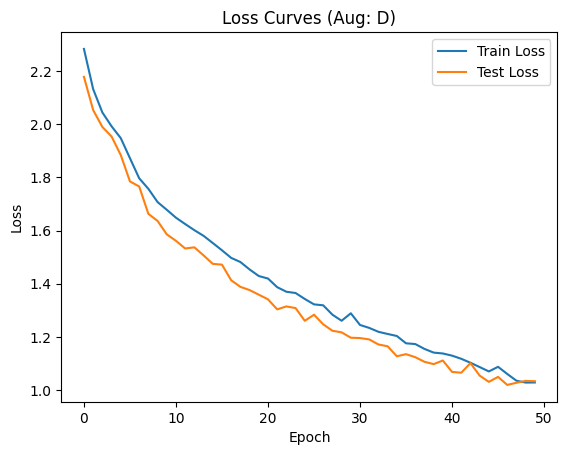

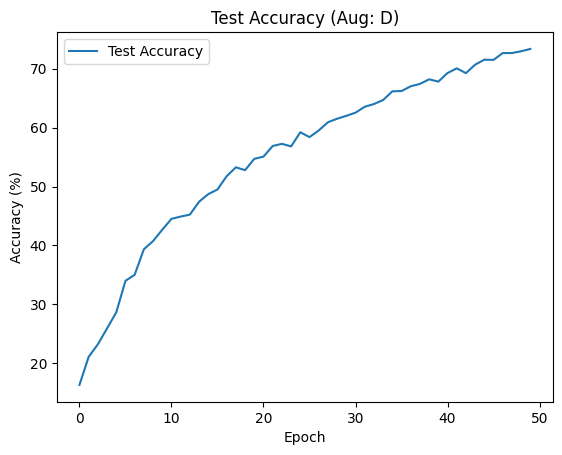

Final Test Accuracy for Augmentation D: 73.36%


In [10]:
# Data Augmentation Variants 
augmentation_types = ["A", "B", "C", "D"]
results_aug = {}
best_aug_config = None
best_aug_acc = 0.0
for aug in augmentation_types:
    print(f"\n--- Training with Data Augmentation Variant {aug} ---")
    base_config1 = best_cfg.copy()  
    train_losses_aug, test_losses_aug, test_accs_aug, _ = run_training(base_config1)
    results_aug[aug] = {"train": train_losses_aug, "test": test_losses_aug, "acc": test_accs_aug}
    plot_loss_curves(train_losses_aug, test_losses_aug, title=f"Loss Curves (Aug: {aug})")
    plot_accuracy(test_accs_aug, title=f"Test Accuracy (Aug: {aug})")
    final_aug_acc = test_accs_aug[-1]
    print(f"Final Test Accuracy for Augmentation {aug}: {final_aug_acc:.2f}%")
    if final_aug_acc > best_aug_acc:
        best_aug_acc = final_aug_acc
        best_aug_config = base_config1

## Data Augmentation Comparison Report 
---

### Final Test Accuracy

| Augmentation Type | Description                                                                 | Final Accuracy |
|-------------------|------------------------------------------------------------------------------|----------------|
| **A**             | RandomCrop + HorizontalFlip                                                 | **74.23%**     |
| **B**             | A + ColorJitter (mild)                                                      | **73.57%**     |
| **C**             | RandomResizedCrop + Flip + ColorJitter (stronger)                          | **74.85%** ✅   |
| **D**             | No strong augmentation, only base transforms                                | **73.36%**     |

---

### Final Loss Values

| Augmentation Type | Final Train Loss | Final Test Loss |
|-------------------|------------------|-----------------|
| **A**             | 0.9896           | 0.9765          |
| **B**             | 1.0379           | 1.0108          |
| **C**             | 1.0016           | 0.9764          |
| **D**             | 1.0288           | 1.0336          |

---

### Key Insights

- **Augmentation C** yields the **best generalization**, with the **highest accuracy (74.85%)** and lowest test loss.
- **ColorJitter** helps but **too much jitter** (as in B) can slightly reduce generalization.
- **Simple augmentations** like A are very effective, often outperforming more aggressive setups.
- **D (minimal augmentation)** underperforms, reaffirming the **value of augmentation**.

---

### Ranking by Accuracy

1. **C** – 74.85%
2. **A** – 74.23%
3. **B** – 73.57%
4. **D** – 73.36%

---

# Visualizations

Files already downloaded and verified
Files already downloaded and verified


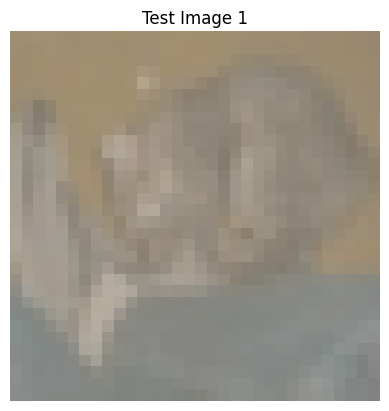

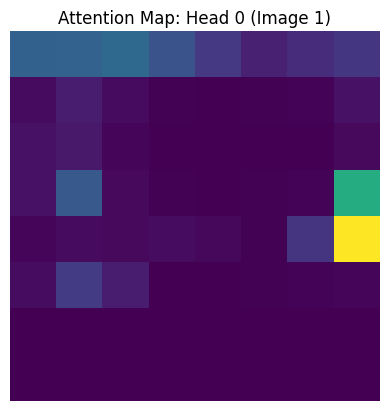

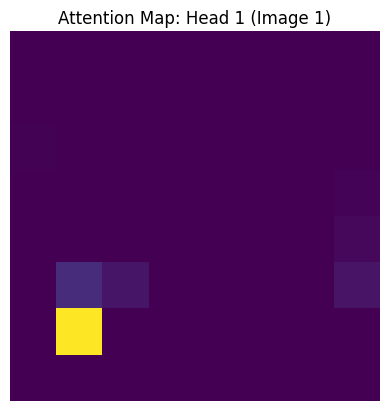

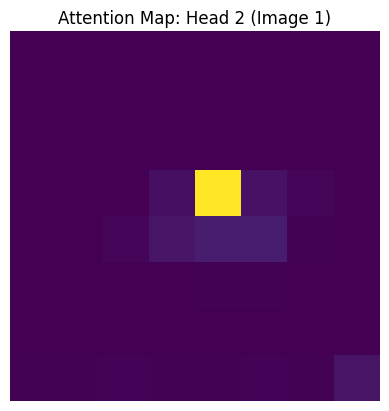

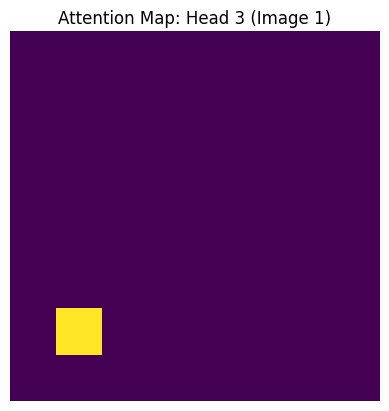

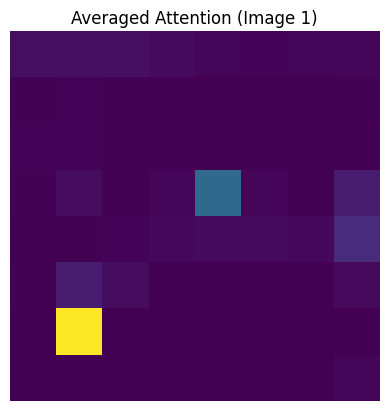

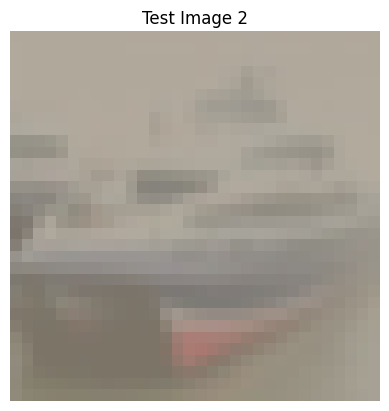

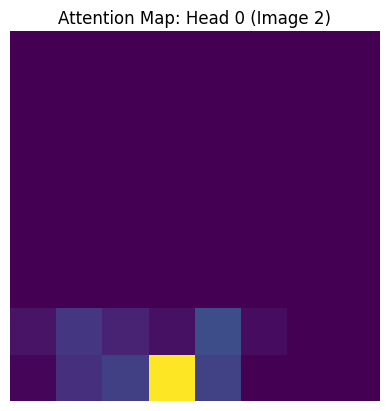

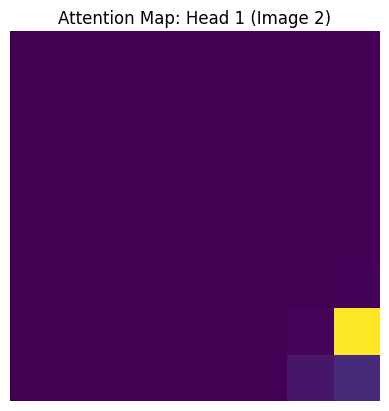

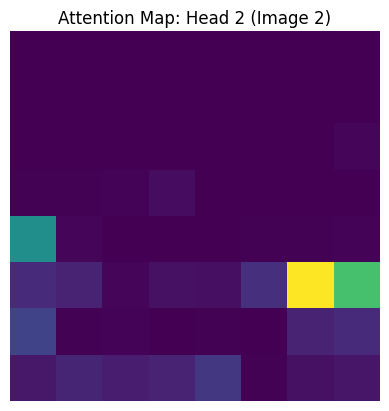

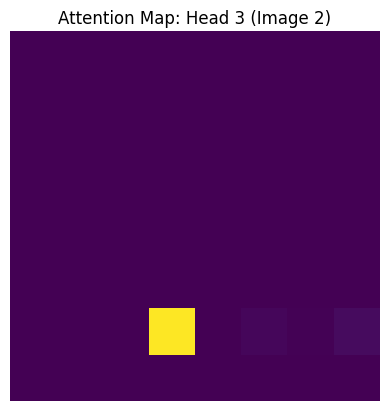

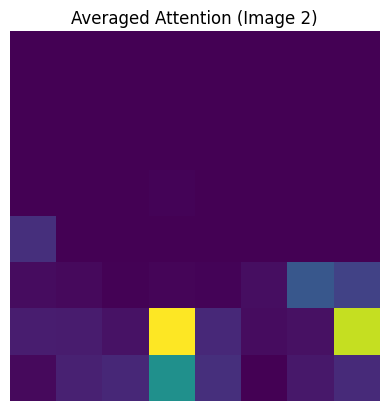

In [14]:
# ViT Attention maps function, visualize attention maps from the [CLS] token to the patch tokens using the ViT model, each layer, and everything
def visualize_vit_attention(model, img):
    device = next(model.parameters()).device
    model.eval()
    with torch.no_grad():
        attn = model.get_last_attention_map(img.to(device))
    attn = attn[0].cpu().numpy()  # (num_heads, N, N)
    num_heads = attn.shape[0]
    cls_attn = attn[:, 0, 1:]
    num_patches = cls_attn.shape[-1]
    grid_size = int(np.sqrt(num_patches))
    cls_attn_maps = cls_attn.reshape(num_heads, grid_size, grid_size)
    for i in range(num_heads):
        plt.figure()
        plt.imshow(cls_attn_maps[i], cmap="viridis")
        plt.title(f"ViT CIFAR Attention Head {i}")
        plt.show()
    avg_attn = np.mean(cls_attn_maps, axis=0)
    plt.figure()
    plt.imshow(avg_attn, cmap="viridis")
    plt.title("ViT CIFAR Attention Averaged")
    plt.show()

# Attention Rollout function
def attention_rollout(model, img, discard_ratio=0.0):
    device = next(model.parameters()).device
    B = img.shape[0]
    num_tokens = model.patch_embed.num_patches + 1
    rollout = torch.eye(num_tokens, num_tokens, device=device).unsqueeze(0).repeat(B, 1, 1)
    x = model.patch_embed(img)
    cls_tokens = model.cls_token.expand(B, -1, -1)
    x = torch.cat((cls_tokens, x), dim=1)
    if model.pos_emb_type in ["1d", "sinusoidal"]:
        x = x + model.pos_embed
    elif model.pos_emb_type == "2d":
        grid_size = int(math.sqrt(x.shape[1]-1))
        pos_patch = torch.cat((
            model.row_embed.repeat(1, grid_size, 1),
            model.col_embed.repeat(1, grid_size, 1)
        ), dim=-1)
        pos = torch.cat((torch.zeros(1, 1, pos_patch.shape[-1], device=device), pos_patch), dim=1)
        x = x + pos
    x = model.dropout(x)
    for block in model.blocks:
        x_norm = block.norm1(x)
        _, attn = block.attn(x_norm, return_attn=True)
        attn_avg = attn.mean(dim=1)   
        if discard_ratio > 0:
            flat_attn = attn_avg.view(attn_avg.size(0), attn_avg.size(1), -1)
            _, indices = flat_attn.topk(int(flat_attn.size(-1)*discard_ratio), dim=-1, largest=False)
            flat_attn.scatter_(-1, indices, 0)
            attn_avg = flat_attn.view_as(attn_avg)
        attn_res = attn_avg + torch.eye(attn_avg.size(-1), device=device).unsqueeze(0)
        attn_res = attn_res / attn_res.sum(dim=-1, keepdim=True)
        rollout = rollout.bmm(attn_res)
        x = block(x)
    return rollout

# Plotting rollout 
def visualize_rollout(model, img, discard_ratio=0.0):
    device = next(model.parameters()).device
    rollout = attention_rollout(model, img.to(device), discard_ratio=discard_ratio)
    cls_rollout = rollout[:, 0, 1:]
    num_patches = cls_rollout.shape[-1]
    grid_size = int(np.sqrt(num_patches))
    cls_rollout_map = cls_rollout.reshape(-1, grid_size, grid_size)[0].detach().cpu().numpy()
    plt.figure()
    plt.imshow(cls_rollout_map, cmap="viridis")
    plt.title("Attention Rollout")
    plt.show()

# Positional embedding visualization
def visualize_pos_emb(model):
    if model.pos_emb_type not in ["1d", "sinusoidal"]:
        print("Visualization requires 1d or sinusoidal positional embeddings.")
        return
    pos_embed = model.pos_embed[0]
    sim = torch.matmul(pos_embed, pos_embed.t())
    plt.figure(figsize=(8,8))
    plt.imshow(sim.detach().cpu().numpy(), cmap="viridis")
    plt.colorbar()
    plt.title("Positional Embedding Similarity")
    plt.show()


# convert a normalized image tensor back to a numpy array  
def unnormalize(img_tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    img = img_tensor.cpu().numpy().transpose(1, 2, 0)
    mean = np.array(mean)
    std = np.array(std)
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

# DINO‑Style Attention Maps on Trained Model
def visualize_trained_model_attention(model, images, patch_size):
    """
    For each image provided, display the original image and the
    attention maps (from the [CLS] token to patch tokens) computed
    by the model. The attention maps should be generated per head (and
    an averaged map across heads also).
    Parameters, model: the trained VisionTransformer, images: a batch of images (tensor) from the test set (shape: [B, C, H, W]) and the patch resolution used when training the model.
    """
    device = next(model.parameters()).device
    model.eval()
    with torch.no_grad():
        for idx in range(min(2, images.shape[0])):
            img = images[idx]
            img_vis = unnormalize(img)
            plt.figure()
            plt.imshow(img_vis)
            plt.title(f"Test Image {idx+1}")
            plt.axis('off')
            plt.show()
            img_batch = img.unsqueeze(0).to(device)
            attn = model.get_last_attention_map(img_batch)   
            attn = attn[0].cpu().numpy()   
            num_heads = attn.shape[0]
            cls_attn = attn[:, 0, 1:]
            num_patches = cls_attn.shape[-1]
            grid_size = int(np.sqrt(num_patches))
            cls_attn_maps = cls_attn.reshape(num_heads, grid_size, grid_size)
            for h in range(num_heads):
                plt.figure()
                plt.imshow(cls_attn_maps[h], cmap="viridis")
                plt.title(f"Attention Map: Head {h} (Image {idx+1})")
                plt.axis('off')
                plt.show()
            avg_attn = np.mean(cls_attn_maps, axis=0)
            plt.figure()
            plt.imshow(avg_attn, cmap="viridis")
            plt.title(f"Averaged Attention (Image {idx+1})")
            plt.axis('off')
            plt.show()

_, test_loader = get_dataloaders(batch_size=128, augment=False)
test_images, _ = next(iter(test_loader))
underlying_model = model.module if hasattr(model, "module") else model
visualize_trained_model_attention(underlying_model, test_images, patch_size=best_cfg.get("patch_size", 4))

Files already downloaded and verified
Files already downloaded and verified


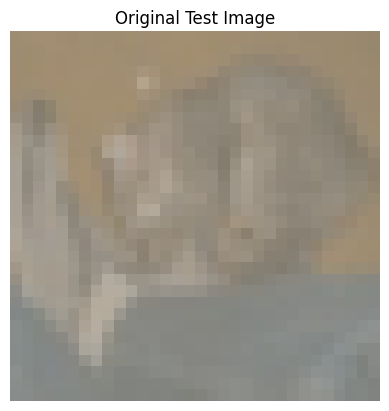


--- Visualizing ViT CIFAR-10 Attention Maps ---


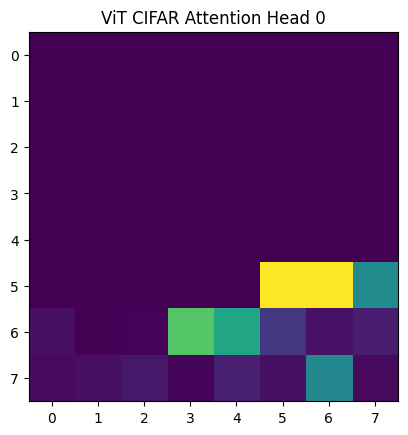

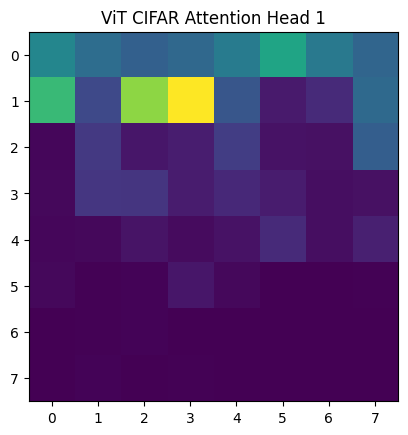

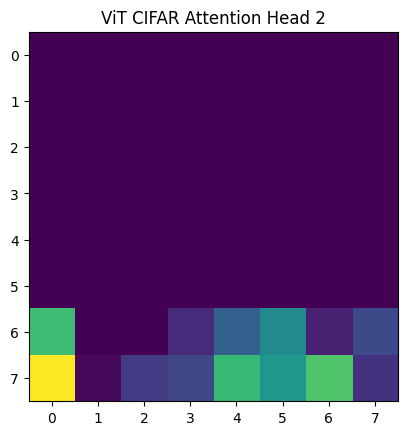

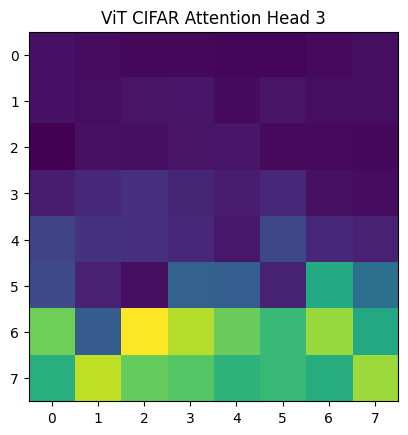

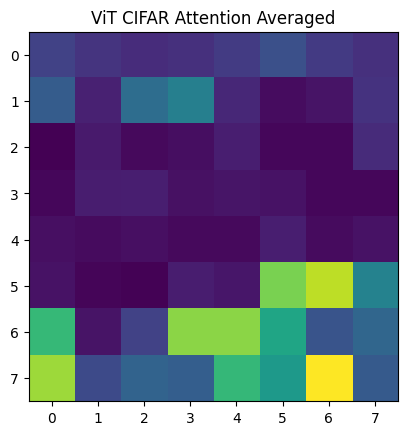

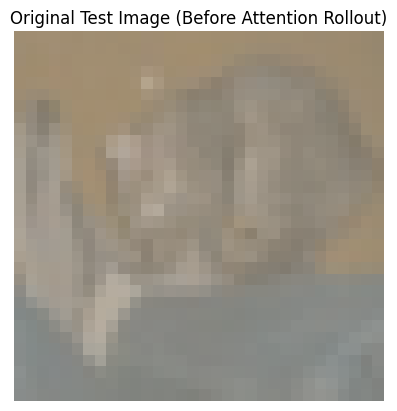


--- Visualizing Attention Rollout ---


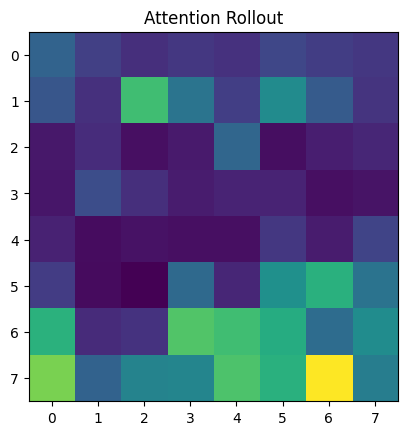

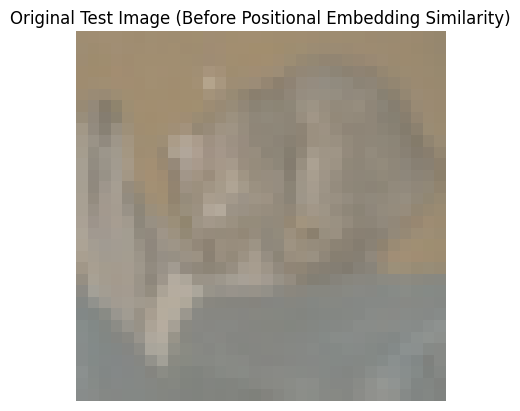


--- Visualizing Positional Embedding Similarity ---


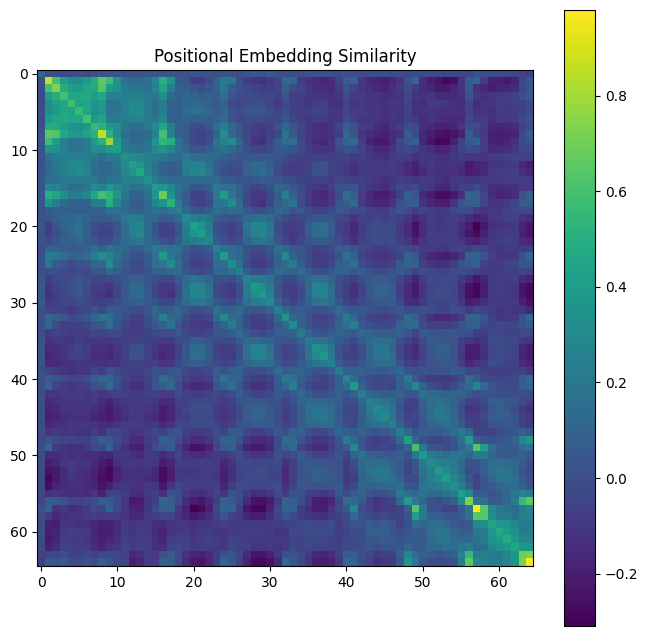

In [13]:
test_loader = get_dataloaders(batch_size=5, augment=False)[1]
test_img, _ = next(iter(test_loader))

if model is not None:
    underlying_model = model.module if hasattr(model, "module") else model
    orig_img = test_img[0]
    orig_img_vis = unnormalize(orig_img)
    plt.figure()
    plt.imshow(orig_img_vis)
    plt.title("Original Test Image")
    plt.axis('off')
    plt.show()
    print("\n--- Visualizing ViT CIFAR-10 Attention Maps ---")
    visualize_vit_attention(underlying_model, test_img)
    plt.figure()
    plt.imshow(orig_img_vis)
    plt.title("Original Test Image (Before Attention Rollout)")
    plt.axis('off')
    plt.show()
    print("\n--- Visualizing Attention Rollout ---")
    visualize_rollout(underlying_model, test_img, discard_ratio=0.0)
    plt.figure()
    plt.imshow(orig_img_vis)
    plt.title("Original Test Image (Before Positional Embedding Similarity)")
    plt.axis('off')
    plt.show()
    print("\n--- Visualizing Positional Embedding Similarity ---")
    if underlying_model.pos_emb_type in ["1d", "sinusoidal"]:
        visualize_pos_emb(underlying_model)

## ViT Attention Visualization Explained

This section explains how different attention maps were plotted from a trained Vision Transformer model.

---

### Test Image Display

Each test image from CIFAR-10 is first **unnormalized** and displayed in its original form.  
This provides a visual reference for interpreting the attention maps.

```python
plt.imshow(img_vis)
plt.title(f"Test Image {idx+1}")
```

---

### Attention Maps: Head-wise Visualization

- For each test image, the attention weights are extracted from the **last transformer block**.
- These maps show how the **[CLS] token attends to each patch token**.
- For each **attention head**, a heatmap is displayed:
  
```python
attn = model.get_last_attention_map(img_batch)
attn = attn[0].cpu().numpy()  # shape: [num_heads, N, N]
cls_attn = attn[:, 0, 1:]     # attention from [CLS] token to patches
cls_attn_maps = cls_attn.reshape(num_heads, grid_size, grid_size)
```

- Plotted via:
```python
plt.imshow(cls_attn_maps[h], cmap="viridis")
plt.title(f"Attention Map: Head {h} (Image {idx+1})")
```

**Brighter patches** in the map indicate **stronger attention**.

---

### Averaged Attention Map (Across All Heads)

- To summarize overall focus, the attention values are **averaged over all heads**:
```python
avg_attn = np.mean(cls_attn_maps, axis=0)
```

- This shows **general model focus** rather than per-head behavior:
```python
plt.imshow(avg_attn, cmap="viridis")
plt.title(f"Averaged Attention (Image {idx+1})")
```

---

### Rollout Visualization

If `attention_rollout()` is used:
- It combines attention **across all layers** by recursively multiplying attention matrices.
- Shows **end-to-end flow of influence** from [CLS] to input patches.

```python
rollout = attention_rollout(model, img.to(device), discard_ratio=0.0)
```

Plotted as:
```python
plt.imshow(cls_rollout_map, cmap="viridis")
plt.title("Attention Rollout")
```

---

### Positional Embedding Visualization

- For **1D or sinusoidal positional embeddings**, this displays **similarity between positions**.
```python
sim = torch.matmul(pos_embed, pos_embed.t())
plt.imshow(sim.detach().cpu().numpy(), cmap="viridis")
plt.title("Positional Embedding Similarity")
```

---

### Summary

| Visualization       | Description |
|---------------------|-------------|
| **Image**           | Unnormalized CIFAR-10 image |
| **Head Attention**  | Focus of each transformer head from [CLS] to patch tokens |
| **Average Attention** | Mean attention across all heads |
| **Rollout (Optional)** | Global flow of attention across all layers |
| **Pos Embedding Sim** | Shows how positional embeddings relate spatially |


This visualization suite demonstrates how a Vision Transformer (ViT) understands and interprets images via attention mechanisms. The plots reveal insights into attention per head, aggregated attention, cumulative rollout, and spatial token relationships via positional embeddings.

---

### Attention Maps (Last Layer, Per Head)

```python
attn = model.get_last_attention_map(img_batch)
```

- Extracts attention from the **[CLS] token to all patch tokens**.
- Reshaped to an \(8 \times 8\) grid corresponding to the 64 patches in CIFAR-10 ViT (assuming 4x4 patch size).
- Attention is visualized **head-by-head**, showing which image patches are emphasized by each head.

```python
plt.imshow(cls_attn_maps[h], cmap="viridis")
plt.title(f"ViT CIFAR Attention Head {h}")
```

> **Bright spots** = strong attention from the [CLS] token.

---

### Averaged Attention Map

```python
avg_attn = np.mean(cls_attn_maps, axis=0)
```

- Averages all heads to get a **summary heatmap**.
- Helpful for observing **global model focus**.

---

### Attention Rollout (Across Layers)

```python
rollout = attention_rollout(model, img.to(device), discard_ratio=0.0)
```

- Cumulatively multiplies attention matrices across layers to compute **global attention flow**.
- Answers: _which image regions influenced the [CLS] token the most across the whole model?_

```python
plt.imshow(cls_rollout_map, cmap="viridis")
plt.title("Attention Rollout")
```

> More complete than single-layer attention, capturing **deep hierarchical patterns**.

---

### Positional Embedding Similarity

```python
sim = torch.matmul(pos_embed, pos_embed.T)
```

- Visualizes how **similar each position embedding is to every other**.
- Diagonal dominance indicates **local structure**; off-diagonal patterns show **global interactions**.

```python
plt.imshow(sim.detach().cpu().numpy(), cmap="viridis")
plt.title("Positional Embedding Similarity")
plt.colorbar()
```

> Useful for understanding **spatial encoding** learned by the transformer.

---

### Summary Table

| Visualization                  | Description                                                |
|-------------------------------|------------------------------------------------------------|
| **Original Image**            | CIFAR-10 test sample (unnormalized)                        |
| **Attention Head Maps**       | Layer-wise [CLS] → patch attention, per head               |
| **Average Attention Map**     | Head-averaged attention from [CLS] to all patches          |
| **Attention Rollout**         | Accumulated attention from [CLS] over **all transformer layers** |
| **Positional Embedding Map**  | Pairwise similarity of position encodings (1D/Sinusoidal)  |

---

These visualizations help diagnose **model interpretability**, **spatial bias**, and **head redundancy** in ViT models. They're especially useful for research and debugging in transformer-based vision architectures.
```